<center>
    <h1> INF491 - Astroinformatics </h1>
    <h2> WavClumps Project:  A Wavelet based algorithm to find clumps and its structure </h2>
    <h3> Martín Villanueva A. <sup>1</sup></h3>
</center>

[1] _martin.villanueva@alumnos.usm.cl - DI UTFSM - June 2016._

## Table of Contents
* [Introduction](#intro)
* [Proposed Solution](#proposal)
* [Concept Test and Experiments](#tests)

<div id='intro' />
## Introduction

In concise words the problem to be addressed consists on given a 3D spectroscopic cube of data (mostly from observations of cold molecular clouds), build an algorithm that automatically can identify clump structures, and determine the hierarchical relationships between them. **Why?**

* Manual methods **doesn’t scale** as fast as the generation of new data observations.
* Size of the images is **huge** and could contain hundreds/thousands of cores.
* Clump identification performed (manually) by astronomers usually didn’t match (**biased methods**).
* Determine the hierarchical relationships between the found clumps is fundamental to understand processes like the **star formation**.
* Clumping algorithms **(GaussClump, ClumpFind, FellWalker)** do not face the problem of finding hierarchical structures.
* State of the Art algorithm that that face this problem (Gregorio et al.) have only woked with **2D data** (collapsed cubes).

<div id='proposal' />
## Proposed Solution

<figure><img src="files/wavclump.png" style="width: 450px; alt='missing'"><figcaption>asdf</figcaption></figure>

<img src="files/cf.png" style="width: 300px;">

<img src="files/fw.png" style="width: 300px;">

<img src="files/level0.png" style="width: 800px;">

<img src="files/level1.png" style="width: 800px;">

<img src="files/level2.png" style="width: 800px;">

<img src="files/level3.png" style="width: 800px;">

<div id='tests' />
## Concept Test and Experiments

In [80]:
%matplotlib inline

import sys
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matlab.engine

sys.path.append('../../ACALIB/')
from acalib.io import graph as gp
from acalib import adata

sys.path.insert(0, './clumping')
import fellwalker as fwalker

### Matlab engine to use

In [2]:
eng = matlab.engine.start_matlab()

### Testing some wavelets

In first place let's see the efects of applying 3D-DWT on a FITS image to perform multiresolution analysis, with different Wavelets families. 

In [3]:
eng.wavemenu(nargout=0)

### Loading FITS data

In [4]:
"""
Loading data
"""
#fits_path = '../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits'
#fits_path = '../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits'
#fits_path = '../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits'
#fits_path = '../../bindata/fits/cubes/M100line.image.fits'
fits_path = '../../bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits'

if os.path.isfile(fits_path):
    ml_data = eng.load_fits(fits_path)
    np_data = np.asarray(ml_data)
    np_data = ma.masked_array(np_data, mask=np.isnan(np_data))
else: print("FITS file doesn't exist")

In [5]:
A,D = eng.mra(ml_data, 'sym5', 3, nargout=2)

In [6]:
fw = fwalker.FellWalker()
caa,clump = fw.run(np_data, verbose=True)

INFO: CAA initialized successfully [fellwalker]
INFO: [Stage 1] Removing small isolated regions [fellwalker]
INFO: [Stage 2] Walking up! [fellwalker]
INFO: Number of clumps found: 99 [fellwalker]
INFO: [Stage 3] Removing small clumps [fellwalker]
INFO: Number of remaining clumps: 76 [fellwalker]
INFO: [Stage 4] Merging clumps with low dip [fellwalker]
INFO: Number of remaining clumps: 22 [fellwalker]
INFO: [Stage 5] Smoothing boundaries [fellwalker]


In [14]:
class WavClumps():
    def __init__(self, wavelet='sym5', nlevel=4, clumping_method='fellwalker'):
        self.wavelet = wavelet
        self.nlevel = nlevel
        #setting the clumping algorithm
        if clumping_method=='fellwalker':
            self.clumping = fwalker.FellWalker()
        elif clumping_method=='clumpfind':
            pass
        #setting default params
        self.default_params()
    
    def default_params(self):
        pass
    
    def mra(self, ml_data):
        """
        Computes approximations and details for each level
        """
        _A,_D = eng.mra(ml_data, self.wavelet, self.nlevel, nargout=2)
        
        #casting to numpy.ndarray
        A = map(np.asarray, _A)
        D = map(np.asarray, _D)
        del _A,_D
        return (A,D)
    
    def dendro_build(self):
        pass
    
    def run(self, np_data, ml_data):
        #perform multiresolution analysis
        A,D = self.mra(ml_data)
        A.insert(0, np_data)
        
        #perform clumping algorithm over original data and each approximation level
        caa = list()
        clumps = list()
        for data in A:
            res = self.clumping.run(data)
            caa.append(res[0])
            clumps.append(res[1])
        
        #storing results
        self.caa = caa
        self.clumps = clumps
        return caa,clumps
    
    def summarize(self):
        for i in range(self.nlevel+1):
            print('Level {0}:'.format(i))
            print('Number of clumps: {0}'.format(len(self.clumps[i])))
            mval = 0
            for pixels in self.clumps[i].values():
                npix = len(pixels)
                if npix>mval: mval = npix
            print('Number of pixels of bigger clump:{0}'.format(mval))
            print('------------------------------------------')

### Instances with differente Wavelet family and 

In [52]:
wc1 = WavClumps(wavelet='sym2', nlevel=4)
wc2 = WavClumps(wavelet='db2', nlevel=4)
wc3 = WavClumps(wavelet='haar', nlevel=4)
wc4 = WavClumps(wavelet='bior1.1', nlevel=4)

In [53]:
caa1, clumps1 = wc1.run(np_data, ml_data)

In [54]:
caa2, clumps2 = wc2.run(np_data, ml_data)

In [55]:
caa3, clumps3 = wc3.run(np_data, ml_data)

In [56]:
caa4, clumps4 = wc4.run(np_data, ml_data)

### Some sumarizing results

In [57]:
wc1.summarize()

Level 0:
Number of clumps: 22
Number of pixels of bigger clump:30359
------------------------------------------
Level 1:
Number of clumps: 11
Number of pixels of bigger clump:42303
------------------------------------------
Level 2:
Number of clumps: 17
Number of pixels of bigger clump:39946
------------------------------------------
Level 3:
Number of clumps: 17
Number of pixels of bigger clump:42357
------------------------------------------
Level 4:
Number of clumps: 7
Number of pixels of bigger clump:66098
------------------------------------------


In [58]:
wc2.summarize()

Level 0:
Number of clumps: 22
Number of pixels of bigger clump:30359
------------------------------------------
Level 1:
Number of clumps: 11
Number of pixels of bigger clump:42303
------------------------------------------
Level 2:
Number of clumps: 17
Number of pixels of bigger clump:39946
------------------------------------------
Level 3:
Number of clumps: 17
Number of pixels of bigger clump:42357
------------------------------------------
Level 4:
Number of clumps: 7
Number of pixels of bigger clump:66098
------------------------------------------


In [59]:
wc3.summarize()

Level 0:
Number of clumps: 22
Number of pixels of bigger clump:30359
------------------------------------------
Level 1:
Number of clumps: 16
Number of pixels of bigger clump:15370
------------------------------------------
Level 2:
Number of clumps: 15
Number of pixels of bigger clump:28132
------------------------------------------
Level 3:
Number of clumps: 6
Number of pixels of bigger clump:22130
------------------------------------------
Level 4:
Number of clumps: 1
Number of pixels of bigger clump:11556
------------------------------------------


In [60]:
wc4.summarize()

Level 0:
Number of clumps: 22
Number of pixels of bigger clump:30359
------------------------------------------
Level 1:
Number of clumps: 16
Number of pixels of bigger clump:15370
------------------------------------------
Level 2:
Number of clumps: 15
Number of pixels of bigger clump:28132
------------------------------------------
Level 3:
Number of clumps: 6
Number of pixels of bigger clump:22130
------------------------------------------
Level 4:
Number of clumps: 1
Number of pixels of bigger clump:11556
------------------------------------------


### Some 2D graphical results

In [61]:
def show_caa_slices(caa, level, dslc=10):
    caa = np.copy(caa)
    caa[caa==-1] = 0
    maxf = caa.shape[2]
    idx_slices = np.linspace(dslc,maxf-dslc,9, dtype=np.int)
    plt.figure(figsize=(15,15))
    for i in range(9):
        f = idx_slices[i]
        plt.subplot(3,3,i+1)
        plt.imshow(caa[:,:,f])
        plt.xlabel('Freq = {0}'.format(f))
        if i==1:
            plt.title('CAA slices at level {0}'.format(level))
    plt.show()

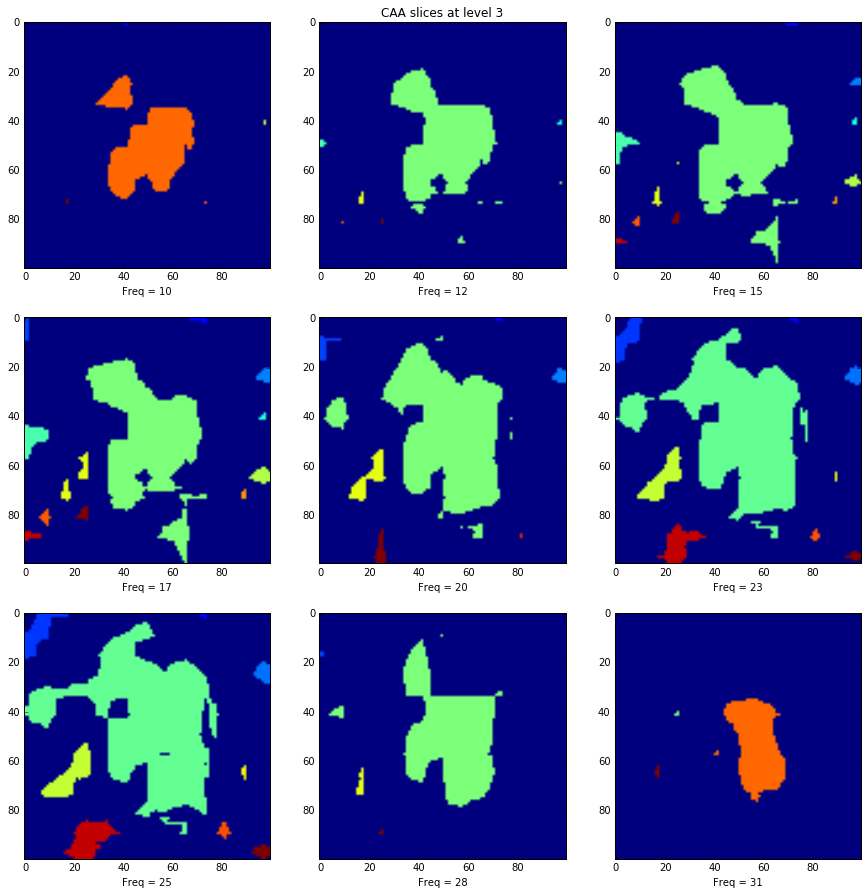

In [63]:
level = 3
show_caa_slices(caa1[level], level)

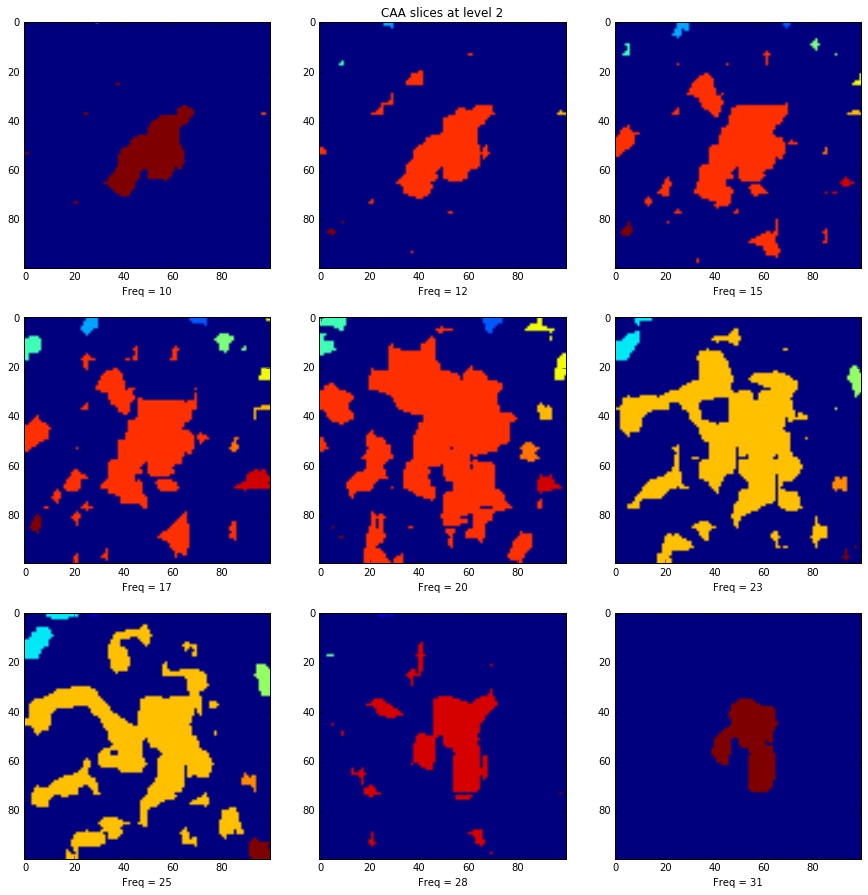

In [64]:
level = 2
show_caa_slices(caa2[level], level)

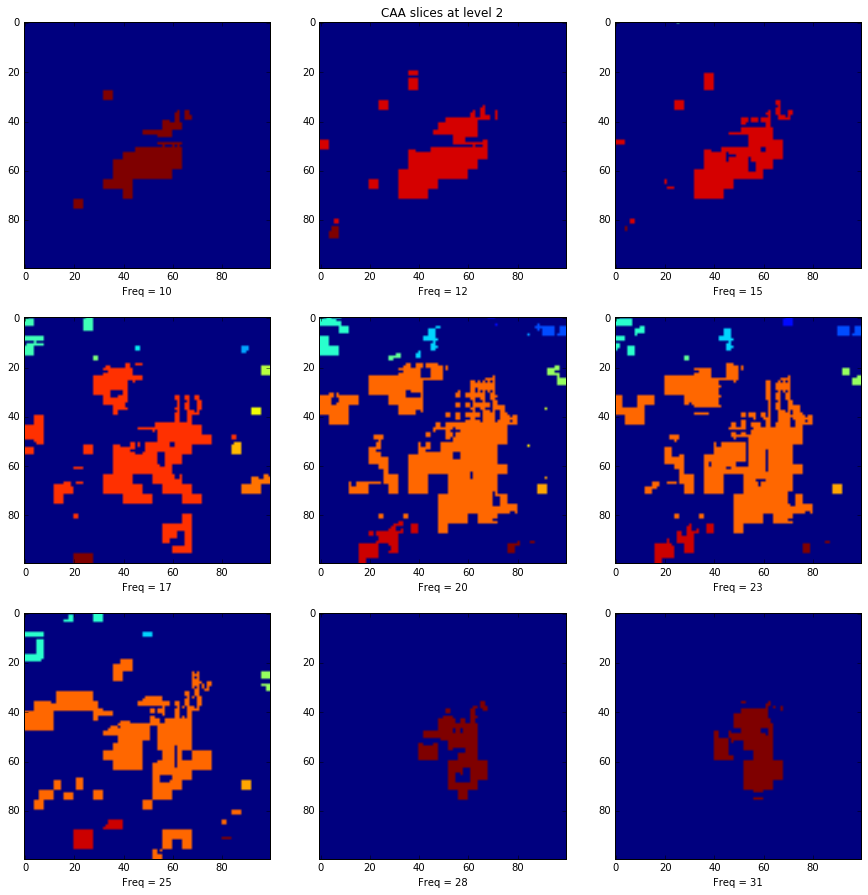

In [65]:
level = 2
show_caa_slices(caa3[level], level)

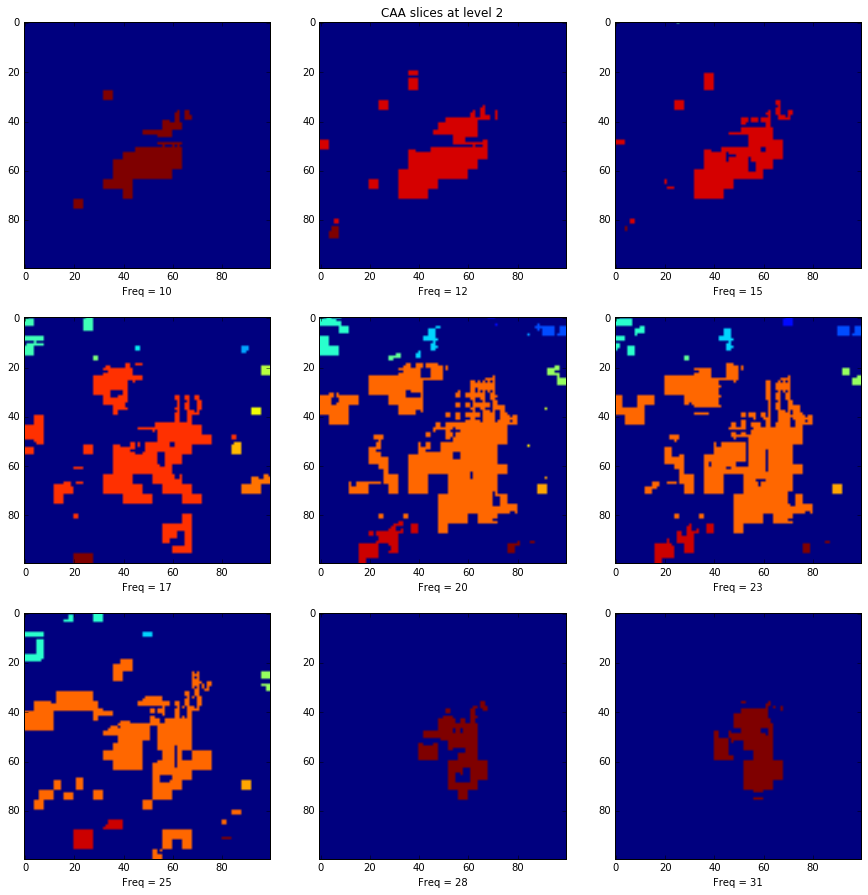

In [66]:
level = 2
show_caa_slices(caa4[level], level)

### Some 3D graphical results

In [82]:
""""
Cube where to load CAAs
"""
cont=ac.AContainer()
cont.load('../../bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits')
cube=cont.primary.copy()

INFO: Processing HDU 0 (Image) [acalib.io.formats]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.formats]


In [84]:
level = 0
cube.data = caa1[0]
gp.volume(cube)

In [ ]:
level = 0
cube.data = caa2[0]
gp.volume(cube)

In [ ]:
level = 0
cube.data = caa2[0]
gp.volume(cube)

In [87]:
level = 3
cube.data = caa4[0]
gp.volume(cube)